In [62]:
import pandas as pd
import numpy as np
import os
import Levenshtein as Lev
from sklearn.utils import shuffle
import datetime as dt
import editdistance
#os.chdir("datasets_full.csv")
os.getcwd()
#os.listdir()

'C:\\Users\\seandesktop\\Desktop\\Schoolin\\Machine Learning\\Project bots\\datasets_full.csv'

### Import Data

Users.csv contains account information for 453 Twitter Users who were identified as bots

In [36]:
#load up the russian bots
rus_users = pd.read_csv('users.csv',
na_filter=False)
rus_users.fillna('')

rus_users[['id','followers_count','statuses_count','favourites_count','friends_count']] =rus_users[['id','followers_count','statuses_count','favourites_count','friends_count']].apply(pd.to_numeric)
rus_users['id'] = rus_users['id'].fillna(0).astype(int)
rus_users['followers_count'] = rus_users['followers_count'].fillna(0).astype(int)
rus_users['statuses_count'] = rus_users['statuses_count'].fillna(0).astype(int)
rus_users['favourites_count'] = rus_users['favourites_count'].fillna(0).astype(int)
rus_users['friends_count'] = rus_users['friends_count'].fillna(0).astype(int)
rus_users.fillna('')

rus_users = rus_users.replace(np.nan, '', regex=True)
rus_users['knownbot'] = 1

rus_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                453 non-null    int32 
 1   location          453 non-null    object
 2   name              453 non-null    object
 3   followers_count   453 non-null    int32 
 4   statuses_count    453 non-null    int32 
 5   time_zone         453 non-null    object
 6   verified          453 non-null    object
 7   lang              453 non-null    object
 8   screen_name       453 non-null    object
 9   description       453 non-null    object
 10  created_at        453 non-null    object
 11  favourites_count  453 non-null    int32 
 12  friends_count     453 non-null    int32 
 13  listed_count      453 non-null    object
 14  knownbot          453 non-null    int64 
dtypes: int32(5), int64(1), object(9)
memory usage: 44.4+ KB


Now we load up the other classes of bots. These classes are:

 - Fake followers
 - Traditional spambots 1
 - Traditional spambots 2
 - Traditional spambots 3
 - Social spambots 1
 - Social spambots 2
 - Social spambots 3

Details about the different types of bots can be found in the attached paper, Bot or Not

In [37]:
#load up the other types of bots
fake_followers = pd.read_csv('fake_followers.csv/users.csv')
fake_followers.fillna('')

trad_spam_1 = pd.read_csv('traditional_spambots_1.csv/users.csv')
trad_spam_2 = pd.read_csv('traditional_spambots_2.csv/users.csv')
trad_spam_3 = pd.read_csv('traditional_spambots_3.csv/users.csv')
#trad_spam_4 = pd.read_csv('social_spambots_4.csv/users.csv')
trad_spam_1 = trad_spam_1.fillna('')
trad_spam_2 = trad_spam_2.fillna('')
trad_spam_3 = trad_spam_3.fillna('')
#trad_spam_4 = trad_spam_4.fillna('')

social_spam_1 = pd.read_csv('social_spambots_1.csv/users.csv')
social_spam_2 = pd.read_csv('social_spambots_2.csv/users.csv')
social_spam_3 = pd.read_csv('social_spambots_3.csv/users.csv')
social_spam_1 = social_spam_1.fillna('')
social_spam_2 = social_spam_2.fillna('')
social_spam_3 = social_spam_3.fillna('')

fake_followers['knownbot'] = 1
trad_spam_1['knownbot'] = 1
trad_spam_2['knownbot'] = 1
trad_spam_3['knownbot'] = 1
#trad_spam_4['knownbot'] = 1
social_spam_1['knownbot'] = 1
social_spam_2['knownbot'] = 1
social_spam_3['knownbot'] = 1


We now load up users verified as genuine

In [38]:
# load up real users
real = pd.read_csv('genuine_accounts.csv/users.csv')
real = real.fillna('')
real['knownbot'] = 0

In [60]:
all_trad_spam = pd.concat([trad_spam_1,trad_spam_2,trad_spam_3])
all_social_spambots = pd.concat([social_spam_1,social_spam_2,social_spam_3])
all_bots = pd.concat([all_trad_spam,all_social_spambots,fake_followers])

#have two data frames, one for all accounts, one for only real vs russian

df_all = pd.concat([real, all_bots])
df_all.head()

df_real_vs_rus = pd.concat([real, rus_users])
df_real_vs_rus = shuffle(df_real_vs_rus)

_____________
### Scoring
We are first going to recreate the paper's findings with russian bots, but without Levantshine distance, as it is computationally intractable to calculate edit distance on a meaningful scale

In [61]:
score = pd.DataFrame()
score['id'] = df_real_vs_rus['id']

Now we apply scoring functions identified by the original researchers to correspond to variables that are relevant to calculating whether an account represents a bot or not. Note that each scoring function, in and of its self, does not indidcate that account is a bot. These variables are used to put important numerical values in a form that can be used with various ml techniques.

In [41]:
#rewrote their scoring functions so it makes sense

# Does 1 mean a bot, does 0 mean a bot
# I have no idea, does it even matter? Should it be 1 and -1?
# I am confused

def scoringLang (row):
    return 1 if row['lang'] == 'en' else 0

def scoringPic (row):
    return 1 if row['profile_image_url'] == '' else 0

def scoringName (row):
    return 1 if row['name'] == '' else 0

def scoringFollower30 (row):
    return 1 if row['followers_count'] < 30 else 0

def scoringGeo (row):
    return 1 if row['geo_enabled'] == '' else 0

def scoringBanner (row):
    return 0 if row['profile_banner_url'] == '' else 1

def scoringStatus50 (row):
    return 0 if row['statuses_count'] > 50 else 1

def scoringTwiceFollow (row):
    return 0 if 2*row['followers_count'] >= row['friends_count'] else 1

def scoringFriends (row):
    return 1 if row['friends_count'] > 1000 else 0

def scoringStatusCount20 (row):
    return 1 if row['statuses_count'] < 20 else 0

def scoringDefaultPic (row):
    return 0 if row['default_profile_image'] == '' else 1

def scoringStatusCountAll (row):
    return 1 if row['statuses_count'] == 0 else 0

def scoringFriendFollow50 (row):
    return 1 if 50*row['followers_count'] <= row['friends_count'] else 0

def scoringFriendFollow100 (row):
    return 1 if 100*row['followers_count'] <= row['friends_count'] else 0

def scoringDesc (row):
    return 1 if row['description'] == '' else 0

def scoringBot (row):
    return 1 if row['knownbot'] == 1 else 0

scoringFuncs = {
    scoringLang: 'lang-en',
    scoringPic: 'profile_pic',
    scoringName: 'has_screen_name',
    scoringFollower30: '30followers',
    scoringGeo: 'geoloc',
    scoringBanner: 'banner_link',
    scoringStatus50: '50tweets',
    scoringTwiceFollow: 'twice_num_followers',
    scoringFriends: '1000friends',
    scoringStatusCount20: '20tweets', #there was a type in their code
    scoringDefaultPic: 'profile_pic',
    scoringStatusCountAll: 'NeverTweeted',
    scoringFriendFollow50: 'fifty_FriendsFollowersRatio',
    scoringFriendFollow100: 'hundred_FriendsFollowersRatio',
    scoringDesc: 'has_description',
    scoringBot: 'knownbot',
}

Now we apply the scoring functions and append the results to a dataframe

In [42]:
for scoring in scoringFuncs.keys():
    df_real_vs_rus.apply (lambda row: scoring (row),axis=1)
    df_real_vs_rus['score'] = df_real_vs_rus.apply (lambda row: scoring (row),axis=1)
    df_real_vs_rus['score'].isnull().values.sum()
    scoreLabel = scoringFuncs[scoring]
    score[scoreLabel] = df_real_vs_rus.apply (lambda row: scoring (row),axis=1)
    #print(score[scoreLabel].head())

____
### Baseline
Below the baseline is calculated by calculating the proportion of accounts in our data set that correspond to a bot. This baseline is representative of a naive bot prediction, and if applied it would classify ~11% of the accounts as a bot

In [43]:
dd = score['knownbot']
bots=0
nonbots=0
for i in dd:
    if i==1:
        bots+=1
    else:
        nonbots+=1
print('Our Baseline is ', bots/(nonbots+bots))

print('The scores of our data is of shape ',score.shape)

Our Baseline is  0.11535523300229182
The scores of our data is of shape  (3927, 16)


____
### Organize data

In [44]:
#organize data
from sklearn.model_selection import ShuffleSplit
if 'knownbot' in score:
    y = score['knownbot'].values # get the labels we want
    del score['knownbot'] # get rid of the class label
    X = score.values # use everything else to predict!
    
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
 test_size = 0.2)
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


__________
### Apply ML algorithms
Now we apply logistic regression on the dataframe that contains scoring information for russian bots and genuine users

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

iter_num=0

#linear regregression, and with X_train, y_train, X_test, and y_test defined

for train_indices, test_indices in cv_object.split(X,y):
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train) # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions
    
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.94529262086514
confusion matrix
 [[687   0]
 [ 43  56]]
====Iteration 1  ====
accuracy 0.9427480916030534
confusion matrix
 [[698   0]
 [ 45  43]]
====Iteration 2  ====
accuracy 0.9491094147582697
confusion matrix
 [[696   0]
 [ 40  50]]


A support vector machine is defined below and used for classification

In [48]:
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

#randomly split the data once again

for train_indices, test_indices in cv_object.split(X,y):

    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

#using a svm, we can now test our data

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train) # train object
y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.9987277353689568
[[692   0]
 [  1  93]]


And a decision tree is applied

In [49]:


#UNDER PROGRESS, tried a Decision Tree and its working to well
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score as acc, precision_score as prec
from sklearn.metrics import confusion_matrix, recall_score as rec

def metrics_calc(y_test, y_pred):
    con_mat = confusion_matrix(y_test, y_pred)
    print("------------Dtree-------")
    print('Precision, no lev = ', prec(y_test, y_pred))
    print('Recall, no lev = ', rec(y_test, y_pred))
    print('Accuracy, no lev = ', acc(y_test, y_pred))
    return con_mat

y_pred = clf.predict(X_test)
con_mat = metrics_calc(y_test, y_pred)
print(con_mat)

------------Dtree-------
Precision, no lev =  1.0
Recall, no lev =  1.0
Accuracy, no lev =  1.0
[[692   0]
 [  0  94]]


And finally we apply an ensemble method

In [14]:
##Ensemble Class from homework

from time import time
from sklearn.metrics import explained_variance_score, precision_score

class EnsembleTest:
    """ Test multiple model performance """
    
    def __init__(self, X_train, y_train, X_test, y_test, _type='regression'):
        """
        initialize data and type of problem
        :param X_train:
        :param y_train:
        :param X_test:
        :param y_test:
        :param _type: regression or classification
        """
        self.scores = {}
        self.execution_time = {}
        self.metric = {}
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.type = _type
        if _type == 'regression':
            self.score_name = 'R^2 score' 
            self.metric_name = 'Explained variance' 
        else:
            self.score_name = 'Mean accuracy score'
            self.metric_name = 'Precision'
            
    def fit_model(self, model, name):
        """
        TODO:
        - Fit the model on train data.
        - Store execution time required to fit.
        - Store scores on test data
        - Predict on test data
        
        Each model passed as parameter has member functions of the following form:
          model.fit(x_train, y_train)
          model.score(x_test, y_test) 
          model.predict(x_test)
        
        :param model: model
        :param name: name of model
        """        
        time_start = time()
        model.fit(self.X_train, self.y_train)
        time_end = time()
        
        self.execution_time[name] = time_end - time_start
        
        self.scores[name] = model.score(self.X_test, self.y_test) 
        predict = model.predict(self.X_test)
        
        if self.type == 'regression':
            self.metric[name] = explained_variance_score(self.y_test, predict)
        elif self.type == 'classification':
            self.metric[name] = precision_score(self.y_test, predict)

    def print_result(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model'         : list(self.metric.keys()),
             self.score_name     : list(self.scores.values()),
             self.metric_name    : list(self.metric.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metric(self):
        """
         There are 3 metrics for each type of experiment: 
             time, metric score, scores
         Produce a bar graph for each of the above metrics
         Each bar graph should have results from all experiments 
             of the same type side by side
         
         Note: The Metric name and score name depend on the type of experiment 
             (regression or classification) 
        """
        metrics = ['time', 'metric score', 'scores']
        index = np.arange(len(metrics))
        values = []
        
        for name in self.metric.keys():
            vals = []
            vals.append(name)
            vals.append(self.execution_time[name])
            vals.append(self.metric[name])
            vals.append(self.scores[name])
            values.append(vals)
        
        #print('VALUES', values)
        fig, ax = plt.subplots()
        p1 = ax.bar(index - .25/1.5, values[0][1:], .25, label=values[0][0])
        p2 = ax.bar( index, values[1][1:], .25, label=values[1][0])
        p3 = ax.bar(index + .25/1.5, values[2][1:], .25, label=values[2][0])
        ax.set_ylabel('scores')
        ax.set_xticks(index)
        ax.set_xticklabels(metrics)
        
        ax.set_title("Performance of %s classifiers" % (self.type,))
        ax.legend()

In [15]:
ensemble_handler = EnsembleTest(
    X_train, y_train, X_test, y_test, _type='regression')

from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(random_state=0)
ensemble_handler.fit_model(DTR, 'decision_tree')
print('Decision Tree Handeled')

from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(random_state=0, n_estimators=1000)
ensemble_handler.fit_model(RFR, 'random_forest')
print("RFR Handeled")

from sklearn.ensemble import AdaBoostRegressor
ABR = AdaBoostRegressor(random_state=0, n_estimators=1000)
ensemble_handler.fit_model(ABR, 'ada_boost')
print("ABR Handeled")

Decision Tree Handeled
RFR Handeled
ABR Handeled


________
### Results

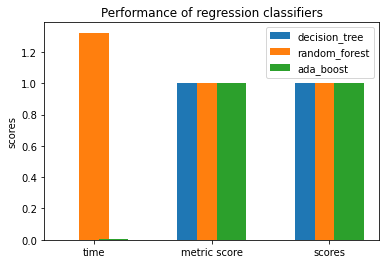

In [17]:
from matplotlib import pyplot as plt
ensemble_handler.plot_metric()
#IGNORE 'TIME' LABEL WE DONT NEED IT

In [18]:
ensemble_handler.print_result()

           Model  R^2 score  Explained variance  Execution time
0  decision_tree   1.000000            1.000000        0.000998
2      ada_boost   1.000000            1.000000        0.002992
1  random_forest   0.999991            0.999991        1.322706


As the above results indicate, the models employed for differentiating between Russian bots and genuince users are extremely accurate. At first glance such results appear too good to be true, and that is likely the case here. 

The issue is that the Russian bots present in our dataset represent the subset of the entire number of bots that are easy to detect. That is, these bots are representative of the low hanging fruit, as many bots were never detected, were not added to the NBC dataset, or were removed by Twitter before they could be added. Unfortunately twitter does not retain data pertaining to accounts known to be fraudulent, which makes it difficult to make a dataset of more sophisticated bots. 

Below, we attempt to identify the other classes of bots present in our data set, as the vast majority of bots on Twitter exists for the purposes of promoting a product, directing traffic to a website, being a fake follower, etc. 

> Note on Twitter data retention and datasets:
>
>> "Twitter initially allowed any Twitter data collected in the proper
way to be shared as a complete data set. Twitter has now amended its policies to only
allow the sharing of account or tweet IDs as a data set. This requires researchers to
populate the data using their own API key in a process known as “rehydrating”. While
this provides more protection for users to have their information removed from
Twitter and not appear in future data sets that are “rehydrated” after the date a user
has deleted their accounts or tweets, it complicates matters for researchers. " (Supervised Machine Learning Bot Detection
Techniques to Identify Social Twitter Bots, 2018)

***************

### Data 2
Now we create a dataframe including the other types of bots, which are:
 - Fake followers
 - Traditional spambots 1
 - Traditional spambots 2
 - Traditional spambots 3
 - Social spambots 1
 - Social spambots 2
 - Social spambots 3

In [52]:
##USING THE df_all dataframe
score_all = pd.DataFrame()
score_all['id'] = df_all['id']

for scoring in scoringFuncs.keys():
    df_all.apply (lambda row: scoring (row),axis=1)
    df_all['score'] = df_all.apply (lambda row: scoring (row),axis=1)
    df_all['score'].isnull().values.sum()
    scoreLabel = scoringFuncs[scoring]
    score_all[scoreLabel] = df_all.apply (lambda row: scoring (row),axis=1)
    #print(score[scoreLabel].head())

______
### Baseline
Below the baseline is calculated by calculating the proportion of accounts in our data set that correspond to a bot. This baseline is representative of a naive bot prediction, and if applied it would classify ~11% of the accounts as one of the above listed varieties of non Russian bot

In [53]:
dd = score_all['knownbot']
bots=0
nonbots=0

for i in dd:
    if i==1:
        bots+=1
    else:
        nonbots+=1
        
print('Our Baseline is ', bots/(nonbots+bots))
print('The scores of our data is of shape ',score_all.shape)

Our Baseline is  0.7376132930513595
The scores of our data is of shape  (13240, 16)


In [54]:
if 'knownbot' in score_all:
    y = score_all['knownbot'].values # get the labels we want
    del score_all['knownbot'] # get rid of the class label
    X = score_all.values # use everything else to predict!
    
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
 test_size = 0.2)
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


_______
### Apply ML algorithms
Below logistic regression is implented, note that it does not outperform the baseline

In [55]:
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)
iter_num=0

for train_indices, test_indices in cv_object.split(X,y):
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train) # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions
    
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

## The results here are also incredibly concerning, it literally is getting all false positives
## I wonder if its because their sorting algo is busted
## Or something else may be afoot

====Iteration 0  ====
accuracy 0.7356495468277946
confusion matrix
 [[   0  700]
 [   0 1948]]
====Iteration 1  ====
accuracy 0.7303625377643505
confusion matrix
 [[   0  714]
 [   0 1934]]
====Iteration 2  ====
accuracy 0.7360271903323263
confusion matrix
 [[   0  699]
 [   0 1949]]


In [56]:
from sklearn.metrics import accuracy_score as acc, precision_score as prec

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

def metrics_calc(y_test, y_pred):
    con_mat = confusion_matrix(y_test, y_pred)
    print("------------Dtree-------")
    print('Precision, no lev = ', prec(y_test, y_pred))
    print('Recall, no lev = ', rec(y_test, y_pred))
    
    print('Accuracy, no lev = ', acc(y_test, y_pred))
    return con_mat

y_pred = clf.predict(X_test)
con_mat = metrics_calc(y_test, y_pred)
print(con_mat)

------------Dtree-------
Precision, no lev =  0.9785166240409208
Recall, no lev =  0.9815289892252437
Accuracy, no lev =  0.9705438066465257
[[ 657   42]
 [  36 1913]]


In [57]:
ensemble_handler_all = EnsembleTest(
    X_train, y_train, X_test, y_test, _type='regression')

from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(random_state=0)
ensemble_handler_all.fit_model(DTR, 'decision_tree')
print('DTR Handeled')

from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(random_state=0, n_estimators=1000)
ensemble_handler_all.fit_model(RFR, 'random_forest')
print("RFR Handeled")

from sklearn.ensemble import AdaBoostRegressor
ABR = AdaBoostRegressor(random_state=0, n_estimators=1000)
ensemble_handler_all.fit_model(ABR, 'ada_boost')
print("ABR Handeled")

DTR Handeled
RFR Handeled
ABR Handeled


_______
### Results 2

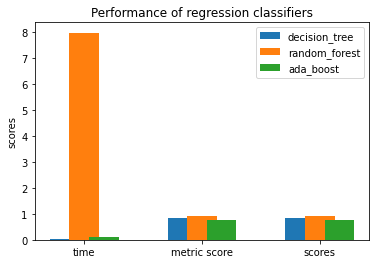

In [58]:
ensemble_handler_all.plot_metric()

In [59]:
ensemble_handler_all.print_result()

           Model  R^2 score  Explained variance  Execution time
1  random_forest   0.899207            0.899259        7.964770
0  decision_tree   0.854223            0.854259        0.013018
2      ada_boost   0.766661            0.768232        0.102017


The results of the models generated for the purpose of differentiating between genuine accounts and non russian bots point towards the presence of a much more difficult problem. Logistic regression failed to outperform our baseline, where as adaboost only comes in ~ 3% above the baseline. Random forest was the hight performer, however it does not perform as high as we would like. The decision tree has a middling performance which is better than the baseline, but not suitable for deployment. 